## 1. 라이브러리 불러오기

In [112]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 

print("라이브러리 로드 완료!")

라이브러리 로드 완료!


## 2. 데이터 불러오기

In [113]:
file_path = 'chirp_dataset.mat'

try:
    with h5py.File(file_path, 'r') as f:
        print(f"변수 목록: {list(f.keys())}")
        
        # 1. 일단 raw 데이터로 읽어옵니다. (Transpose .T 적용)
        X_raw = np.array(f['X_noisy']).T
        Y_raw = np.array(f['Y_clean']).T
        SNR_log = np.array(f['SNR_log']).T
        
        # 2. 구조체 형태인지 확인하고, 진짜 복소수(Complex)로 변환합니다.
        # MATLAB v7.3은 복소수를 ('real', 'imag') 필드를 가진 구조체로 저장합니다.
        
        # X_noisy 변환
        if X_raw.dtype.names is not None and 'real' in X_raw.dtype.names:
            X_noisy = X_raw['real'] + 1j * X_raw['imag']
        else:
            X_noisy = X_raw # 이미 복소수라면 그대로 사용

        # Y_clean 변환
        if Y_raw.dtype.names is not None and 'real' in Y_raw.dtype.names:
            Y_clean = Y_raw['real'] + 1j * Y_raw['imag']
        else:
            Y_clean = Y_raw

    print("\n데이터 로드 및 복소수 변환 성공!")
    print(f"X_noisy shape: {X_noisy.shape}")
    print(f"X_noisy type: {X_noisy.dtype}") # complex128 이라고 나오면 성공!
    
except FileNotFoundError:
    print(f"파일을 찾을 수 없습니다: {file_path}")
except Exception as e:
    print(f"에러 발생: {e}")

변수 목록: ['SNR_log', 'X_noisy', 'Y_clean']

데이터 로드 및 복소수 변환 성공!
X_noisy shape: (5000, 1024)
X_noisy type: complex128


## 3. 시각화 (그래프 그리기)

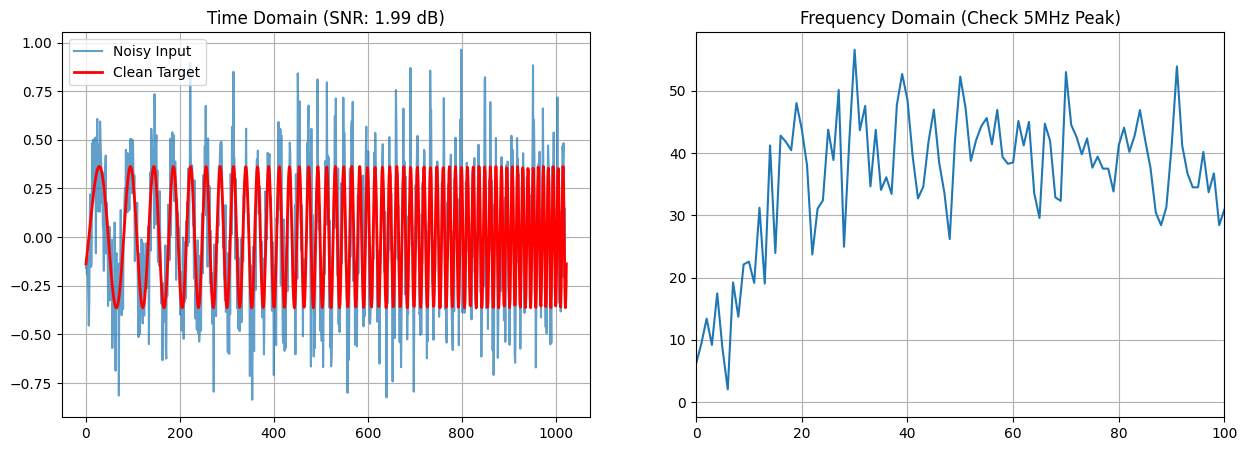

In [114]:
idx = 0 # 확인하고 싶은 데이터 번호 (0 ~ 4999)
fs = 100e6

plt.figure(figsize=(15, 5))

# 1. 시간 영역 (Time Domain)
plt.subplot(1, 2, 1)
plt.plot(np.real(X_noisy[idx]), label='Noisy Input', alpha=0.7)
plt.plot(np.real(Y_clean[idx]), 'r', label='Clean Target', linewidth=2)
plt.title(f'Time Domain (SNR: {SNR_log[idx][0]:.2f} dB)')
plt.legend()
plt.grid(True)

# 2. 주파수 영역 (Frequency Domain)
plt.subplot(1, 2, 2)
# FFT 계산
fft_data = np.abs(np.fft.fft(X_noisy[idx]))
# 주파수 축 생성 (대략적인 인덱스로 표현)
plt.plot(fft_data)
plt.title('Frequency Domain (Check 5MHz Peak)')
plt.xlim(0, 100) # 앞부분 확대
plt.grid(True)

plt.show()



from scipy.signal import spectrogram

def plot_spectrogram(x, fs, title):
    """
    x: 1D numpy array (real signal)
    fs: sampling frequency
    """
    f, t, Sxx = spectrogram(x, fs=fs, nperseg=256, noverlap=128)

    plt.pcolormesh(t, f, 10*np.log10(Sxx + 1e-12), shading='gouraud')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.title(title)
    plt.colorbar(label='Power (dB)')
    plt.ylim(0, fs/2)


## 4. RadarDataset 클래스 정의

In [115]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np

class RadarDataset(Dataset):
    def __init__(self, mat_file_path):
        """
        mat_file_path: .mat 파일의 경로
        """
        self.file_path = mat_file_path
        
        # 데이터 로드 (메모리에 올리기)
        with h5py.File(self.file_path, 'r') as f:
            # 1. 데이터 읽기 및 전치 (.T) -> (N, Length)
            X_raw = np.array(f['X_noisy']).T
            Y_raw = np.array(f['Y_clean']).T
            
            # 2. 복소수 변환 (구조체 -> complex128)
            # MATLAB v7.3 이슈 해결 코드
            if X_raw.dtype.names is not None and 'real' in X_raw.dtype.names:
                self.X_data = X_raw['real'] + 1j * X_raw['imag']
                self.Y_data = Y_raw['real'] + 1j * Y_raw['imag']
            else:
                self.X_data = X_raw
                self.Y_data = Y_raw
                
        print(f"데이터셋 로드 완료: {len(self.X_data)} 샘플")

    def __len__(self):
        # 데이터의 총 개수 반환
        return len(self.X_data)

    def __getitem__(self, idx):
        # 인덱스(idx)에 해당하는 데이터 하나를 가져오는 함수
        
        # 1. 데이터 하나 꺼내기
        x_complex = self.X_data[idx] # (1024,) 복소수
        y_complex = self.Y_data[idx] # (1024,) 복소수
        
        # 2. 딥러닝 입력용 변환: (Real, Imag) 2채널로 분리
        # 결과 형태: [2, 1024]
        # np.stack을 써서 두 줄로 쌓습니다.
        x_2ch = np.stack([np.real(x_complex), np.imag(x_complex)], axis=0)
        y_2ch = np.stack([np.real(y_complex), np.imag(y_complex)], axis=0)
        
        # 3. PyTorch Tensor로 변환 (float32 사용)
        # 딥러닝은 보통 32비트 실수를 씁니다.
        x_tensor = torch.from_numpy(x_2ch).float()
        y_tensor = torch.from_numpy(y_2ch).float()
        
        return x_tensor, y_tensor

## 5. 잘 만들어졌는지 테스트 (검증)

In [116]:
from torch.utils.data import random_split

# 1. 전체 데이터셋 생성
full_dataset = RadarDataset('chirp_dataset.mat')
total_size = len(full_dataset)

# 2. 비율 설정 (70% 학습, 15% 검증, 15% 테스트)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42) # 결과 재현을 위해 시드 고정
)

# 3. 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"학습: {len(train_dataset)} | 검증: {len(val_dataset)} | 테스트: {len(test_dataset)}")

데이터셋 로드 완료: 5000 샘플
학습: 3500 | 검증: 750 | 테스트: 750


In [117]:
import os

print("현재 위치:", os.getcwd())
print("내 눈앞에 보이는 파일들:", os.listdir())

if 'chirp_dataset.mat' in os.listdir():
    print("👉 파일이 바로 여기 있습니다! 'chirp_dataset.mat'만 쓰시면 됩니다.")
else:
    print("👉 파일이 안 보입니다. 파일이 다른 폴더에 있거나 이름이 다를 수 있습니다.")

현재 위치: /home/jaehyeon5004/Radar_Denoising
내 눈앞에 보이는 파일들: ['best_denoise_model.pth', '.gitignore', '.git', 'sine_dataset.mat', 'check_data.ipynb', 'chirp_dataset.mat']
👉 파일이 바로 여기 있습니다! 'chirp_dataset.mat'만 쓰시면 됩니다.


## 6. 1D CNN 모델 설계

In [118]:
print("\n[Deep Learning] 학습 준비 및 시작...")

# 1. GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 장치(Device): {device}")

# 2. 1D CNN 모델 정의 (Denoising Autoencoder)
class RadarDenoiseNet(nn.Module):
    def __init__(self):
        super(RadarDenoiseNet, self).__init__()
        
        # [Encoder] 특징 추출 (2채널 -> 64채널 -> 128채널)
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=2, out_channels=64, kernel_size=9, padding=4),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        
        # [Decoder] 신호 복원 (128채널 -> 64채널 -> 2채널)
        self.decoder = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=2, kernel_size=3, padding=1)
            # 마지막은 Activation 없이 선형 출력 (실수값 예측)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 3. 모델 및 학습 파라미터 설정
model = RadarDenoiseNet().to(device)
criterion = nn.MSELoss() # 신호 복원 오차(Mean Squared Error)
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 20 # 학습 반복 횟수

# 기록을 위한 리스트
train_loss_history = []
val_loss_history = []
best_val_loss = float('inf') 

print(f"학습 시작 (총 {EPOCHS} Epochs)...")

for epoch in range(EPOCHS):
    # --- [Training] ---
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
    
    avg_train_loss = running_train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    # --- [Validation] ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad(): # 검증 시에는 기울기 계산을 꺼서 메모리 절약
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            
    avg_val_loss = running_val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)

    # 5에폭마다 결과 출력 및 베스트 모델 저장
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_denoise_model.pth')

print("학습 완료!")


[Deep Learning] 학습 준비 및 시작...
사용 장치(Device): cuda
학습 시작 (총 20 Epochs)...
Epoch [1/20] Train Loss: 0.019875 | Val Loss: 0.004116
Epoch [5/20] Train Loss: 0.002985 | Val Loss: 0.004222
Epoch [10/20] Train Loss: 0.002716 | Val Loss: 0.002456
Epoch [15/20] Train Loss: 0.002322 | Val Loss: 0.003873
Epoch [20/20] Train Loss: 0.002320 | Val Loss: 0.002220
학습 완료!


## 7. 결과 검증 및 시각화

/tmp/ipykernel_1474/4267855861.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_denoise_model.pth'))


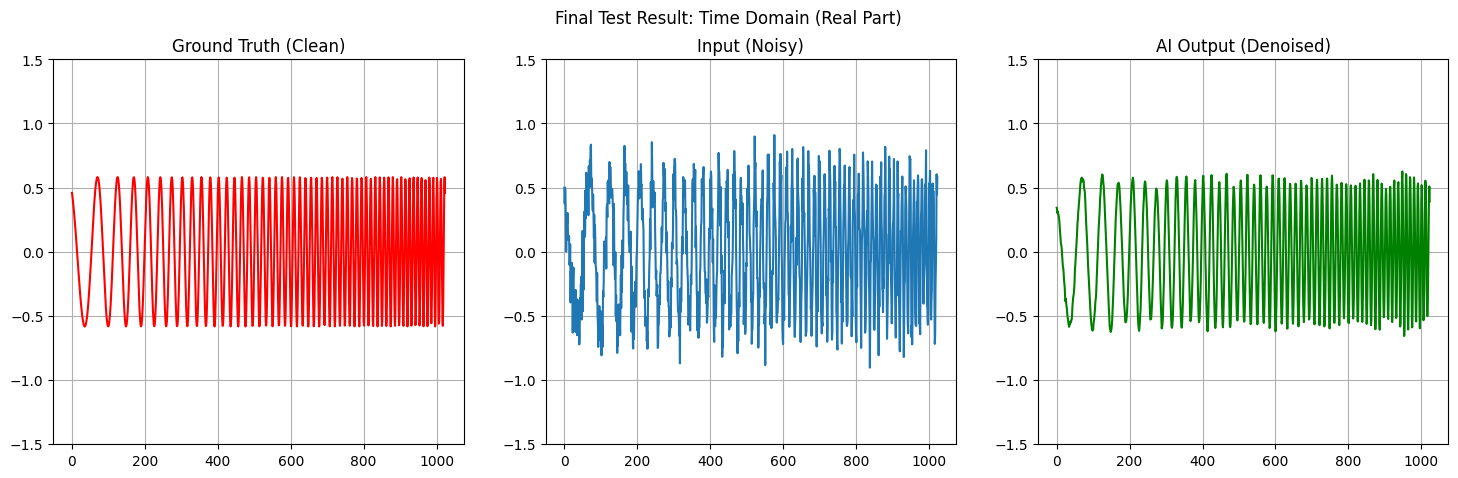

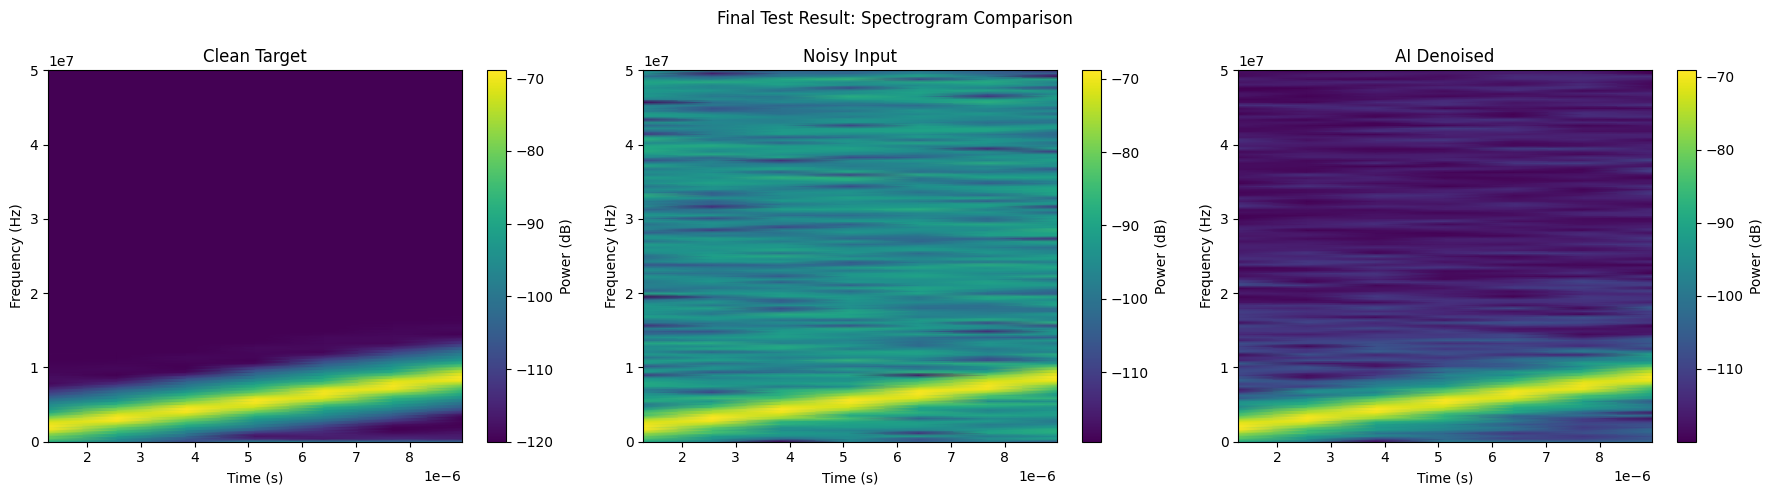

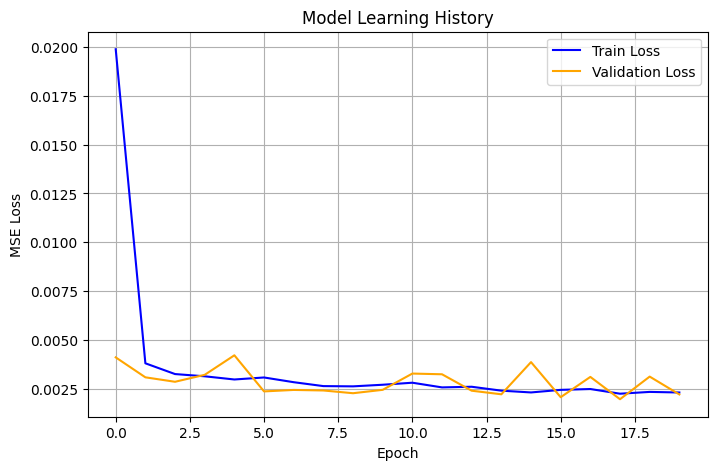

In [119]:
# 1. 검증 과정에서 저장했던 '최적의 가중치'를 불러옵니다.
# 마지막 에폭의 모델보다, 검증 오차가 가장 낮았던 모델이 진짜 실력입니다.
model.load_state_dict(torch.load('best_denoise_model.pth'))
model.eval() 

with torch.no_grad():
    # 2. 중요: 'dataloader'가 아니라 'test_loader'에서 데이터를 가져옵니다.
    # 모델이 학습(Train)이나 튜닝(Val) 중에 단 한 번도 본 적 없는 순수 테스트 데이터입니다.
    test_in, test_target = next(iter(test_loader)) 
    test_in = test_in.to(device)
    
    # AI 모델로 예측 (Denoising)
    prediction = model(test_in)
    
    # 그래프를 그리기 위해 첫 번째 샘플(index 0)을 CPU로 가져옵니다.
    in_np = test_in[0].cpu().numpy()      # [2, 1024]
    target_np = test_target[0].cpu().numpy() # [2, 1024]
    pred_np = prediction[0].cpu().numpy()    # [2, 1024]

    # --- 신호 파형 비교 (Real Part) ---
    plt.figure(figsize=(18, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(target_np[0, :], 'r')
    plt.title("Ground Truth (Clean)")
    plt.ylim(-1.5, 1.5); plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(in_np[0, :])
    plt.title("Input (Noisy)")
    plt.ylim(-1.5, 1.5); plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.plot(pred_np[0, :], 'g')
    plt.title("AI Output (Denoised)")
    plt.ylim(-1.5, 1.5); plt.grid(True)
    
    plt.suptitle("Final Test Result: Time Domain (Real Part)")
    plt.show()

    # --- 스펙트로그램 비교 ---
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plot_spectrogram(target_np[0, :], fs, "Clean Target")
    plt.subplot(1, 3, 2)
    plot_spectrogram(in_np[0, :], fs, "Noisy Input")
    plt.subplot(1, 3, 3)
    plot_spectrogram(pred_np[0, :], fs, "AI Denoised")
    plt.suptitle("Final Test Result: Spectrogram Comparison")
    plt.tight_layout(); plt.show()

    # --- 학습 곡선 확인 ---
    plt.figure(figsize=(8, 5))
    plt.plot(train_loss_history, label='Train Loss', color='blue')
    plt.plot(val_loss_history, label='Validation Loss', color='orange')
    plt.title("Model Learning History")
    plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
    plt.legend(); plt.grid(True)
    plt.show()